# Optimizing Classification Weights using Alpha-Loss



## Packages & libraries

In [326]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import seaborn as sns
import pandas as pd
plt.rcParams['figure.dpi'] =140
plt.rcParams['text.usetex']=True

In [327]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

## Helper Functions

In [328]:
def gmm_generator_function(N, n_min, Mu, Sigma):

  n_maj = N - n_min

  # initializes mean and covariance matrices for class +1
  A = Sigma
  b1_full = np.tile(Mu[0,:],(n_min,1)).T

  # initializes mean for class -1
  b2_full = np.tile(Mu[1,:],(n_maj,1)).T

  b_full = np.hstack((b1_full, b2_full))

  # generates random [2,N] matrix ~ N(0,1)
  np.random.seed(42)
  Z = np.random.randn(2,N)

  # convert ~N(0,1) random points to desired distributions 
  # via A*Z+b ~N(b, AA^T)
  X = np.dot(A,Z)+b_full

  # initialize vector with labels
  y1 = -np.ones((n_min,1))
  y2 = np.ones((n_maj,1))

  y = np.vstack((y1,y2))

  return X.T, y
 



In [329]:
def sigmoid(z):
  a = 1 + np.exp(-z)
  return 1/a

In [330]:
def alpha_loss_calc_torch(X_tensor, y_tensor, theta_1, theta_2, theta_3, alpha):

    X_tensor_1 = X_tensor[:,0]
    X_tensor_2 = X_tensor[:,1]
    X_tensor_1 = X_tensor_1.view(X_tensor_1.size(0),1)
    X_tensor_2 = X_tensor_2.view(X_tensor_2.size(0),1)

    X_T_theta = theta_1 + theta_2*X_tensor_1 + theta_3*X_tensor_2

    sig_tensor = (torch.special.expit(X_T_theta))

    if alpha == 1:
        t1 = y_tensor * torch.log(sig_tensor)
        t2 = (1-y_tensor) * torch.log(1-sig_tensor)
        torch_loss = torch.mean(-(t1 + t2))

    else:
        pow = 1-(1/alpha)
        sig_power_1 = torch.pow(sig_tensor, pow)
        sig_power_2 = torch.pow(1-sig_tensor, pow)       
        torch_loss = (alpha/(alpha-1))*(1 - y_tensor*sig_power_1 - (1-y_tensor)*sig_power_2)

    # with torch.no_grad():
    #     mean_loss = torch.mean(loss)

    # mean_loss = torch.mean(loss)
    mean_loss = torch.mean(torch_loss)
    return mean_loss

In [331]:
def alpha_loss(output,target,my_alpha):
    loss = 0
    if my_alpha == 1.0:
        loss = torch.mean(torch.sum(-target*torch.log(torch.softmax(output,dim=1) + 1e-8),dim=1))
    else:
        alpha = torch.FloatTensor([my_alpha]).cuda()
        one = torch.FloatTensor([1.0]).cuda()
        loss = (alpha/(alpha-one))*torch.mean(torch.sum(target*(one - torch.softmax(output,dim=1).pow(one - (one/alpha))),dim=1))
    return loss

In [332]:
from scipy.stats import multivariate_normal as norm
def posterior(x, p_y, mu_1, mu_2, sigma):
    return p_y * norm.pdf(x, mean=mu_1, cov = sigma) / (p_y * norm.pdf(x, mean=mu_1, cov = sigma) + (1-p_y)*norm.pdf(x,mean=mu_2, cov = sigma))

In [333]:
def alpha_tilted_posterior(x, alpha, p_flip, p_y, mu_1, mu_2, sigma):
    pos = posterior(x,p_y, mu_1, mu_2, sigma)
    p = p_flip*(1-pos) + (1-p_flip)*pos
    return np.power(p,alpha) / (np.power(p,alpha) + np.power(1-p,alpha))

In [334]:
class GMM_Data(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

## Model parameters

## Generate GMM

2000


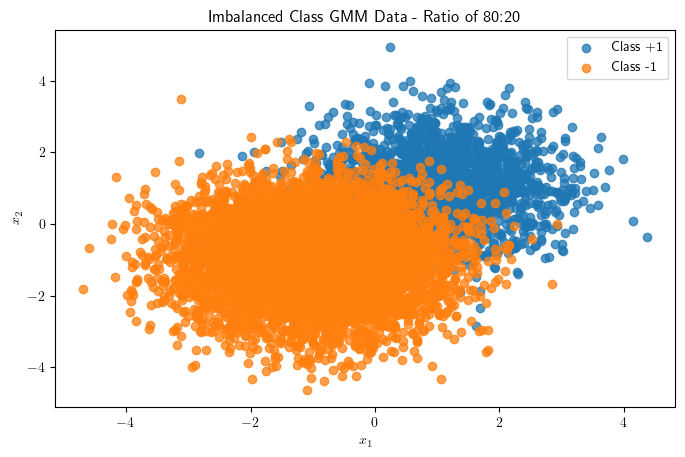

In [335]:
sigma = np.eye(2)
mu1 = -1
mu = np.array([[mu1, mu1], [-mu1, -mu1]])

N = int(1e4)
M = int(1e4)
m = 2
n_line = 100

# set the level of class imbalance
pmix = 0.8
mult = N/100
nmix = int(pmix*N)

# set the amount of label noise
pflip = 0.0

# generates GMM Data
[X,y] = gmm_generator_function(N,nmix,mu, sigma)

# add label noise (if applicable)
if (pflip != 0):
    index_list = random.sample(range(nmix), int(pflip*N/2))
    index_list_1 = random.sample(range(nmix,N), int(pflip*N/2))
    for i in index_list:
        y[i] = -y[i]
    for i in index_list_1:
        y[i] = -y[i]


# convert labels to {0,1}
y=(y+1)/2
# y_trans = (y+1)/2
y_trans = y
num_ones = int(sum(y_trans))
x_ones = np.zeros((num_ones,2))
x_zeros = np.zeros((M-num_ones,2))
count_1 = 0
count_0 = 0

for i in range(M):
  if y_trans[i] == 1:
    x_ones[count_1,:] = X[i,:]
    count_1 += 1
  else:
    x_zeros[count_0,:] = X[i,:]
    count_0 += 1

print(np.count_nonzero( - y.reshape(1,-1)))

plt.figure(figsize=(8,5), dpi=100)
plt.scatter(x_ones[:,0], x_ones[:,1], label='Class +1', alpha=0.75)
plt.scatter(x_zeros[:,0], x_zeros[:,1], label='Class -1', alpha=0.75)
plt.title('Imbalanced Class GMM Data - Ratio of {}:{}'.format(int(nmix/mult), int((N-nmix)/mult)))
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend()

In [336]:
X_tensor = torch.from_numpy(X).float().to(device)
y_tensor = torch.from_numpy(y).float().to(device)

## Alpha Values

In [337]:
# a = [.65, .8, 1, 2.5, 4]   # values of alpha
# num_a = max(np.shape((a)))

alpha_vals = np.linspace(0.5, 20, num=40)
print(alpha_vals)
num_a = len(alpha_vals)

[ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.
 14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20. ]


## Main gradient descent loop

In [338]:
alpha_count = 0

theta1_vals = []
theta2_vals = []
theta3_vals = []
loss_vals = []

eta =1e-2
n_epochs = 2000
experiments= 25

thetas_super_storage = np.zeros((len(alpha_vals),3))

for alpha in alpha_vals:

    print('\nStarting SGD for alpha={}'.format(alpha))
    for exp in range(experiments):

        # send current iteration's alpha to device
        alpha_tensor = torch.tensor(alpha, requires_grad=False, dtype=torch.float, device=device)

        np.random.seed(exp)
        torch.manual_seed(exp)
        theta_init = np.random.rand(3)
        # initialize starting theta
        theta_1 = torch.tensor(theta_init[0],requires_grad=True, dtype=torch.float, device=device)
        theta_2 = torch.tensor(theta_init[1],requires_grad=True, dtype=torch.float, device=device)
        theta_3 = torch.tensor(theta_init[2],requires_grad=True, dtype=torch.float, device=device)    
        print('starting value of theta: [{},{},{}]'.format(theta_1, theta_2, theta_3))


        optimizer = optim.SGD([theta_1, theta_2, theta_3], lr=eta)

        for epoch in range(n_epochs):

            optimizer.zero_grad() 
            loss = alpha_loss_calc_torch(X_tensor, y_tensor, theta_1, theta_2, theta_3, alpha_tensor)  

            loss.backward()

            optimizer.step()



        theta1_vals.append(theta_1.item())
        theta2_vals.append(theta_2.item())
        theta3_vals.append(theta_3.item())

        loss_vals.append(loss.item())

    theta_avg = np.array([np.mean(theta1_vals), np.mean(theta2_vals), np.mean(theta3_vals)])
    # print('Final alpha-loss for alpha={} is: {}'.format(alpha, loss.item()))
    print('Final thetas for alpha={} are: {}, {}, {}\n'\
          .format(alpha, theta_avg[0], theta_avg[1], theta_avg[2]))
    
    thetas_super_storage[alpha_count,:] = np.array([theta_avg[0], theta_avg[1], theta_avg[2]])

    alpha_count += 1


Starting SGD for alpha=0.5
starting value of theta: [0.54881352186203,0.7151893377304077,0.6027633547782898]
starting value of theta: [0.4170219898223877,0.7203245162963867,0.00011437481589382514]
starting value of theta: [0.4359948933124542,0.02592623233795166,0.5496624708175659]
starting value of theta: [0.5507978796958923,0.7081478238105774,0.2909047305583954]
starting value of theta: [0.9670298099517822,0.5472322702407837,0.972684383392334]
starting value of theta: [0.22199317812919617,0.870732307434082,0.20671916007995605]
starting value of theta: [0.8928601741790771,0.33197981119155884,0.821229100227356]
starting value of theta: [0.07630828768014908,0.7799187898635864,0.4384092390537262]
starting value of theta: [0.8734294176101685,0.9685406684875488,0.8691945672035217]
starting value of theta: [0.010374153964221478,0.501874566078186,0.4957732856273651]
starting value of theta: [0.771320641040802,0.0207519493997097,0.6336482167243958]
starting value of theta: [0.1802696883678436

## Determine the classification boundary for each alpha

In [339]:
# y_trans = (y+np.ones((M,1)))/2
y_trans = y
num_ones = int(sum(y_trans))
x_ones = np.zeros((num_ones,2))
x_zeros = np.zeros((M-num_ones,2))
count_1 = 0
count_0 = 0

for i in range(M):
  if y_trans[i] == 1:
    x_ones[count_1,:] = X[i,:]
    count_1 += 1
  else:
    x_zeros[count_0,:] = X[i,:]
    count_0 += 1


# calculate separating lines for each value of alpha
num_points = 100
x1 = np.linspace(-4, 4, num_points)
x2 = np.zeros((num_points,num_a))

for p in range(num_a):
  theta = thetas_super_storage[p,:]
  for q in range(num_points):
    x2[q,p] = -(theta[1]/theta[2])*x1[q] - (theta[0]/theta[2])
    


## Calculate Bayes' Optimal Line

In [340]:
pmix2 = pmix

rng = 4
x1 = np.linspace(-rng, rng, n_line).reshape((100,1))
x3 = np.zeros((n_line,1))

inter1 = np.dot(mu[0,:],mu[0,:])
inter2 = np.dot(mu[1,:],mu[1,:])
inter3 = mu[1,:] - mu[0,:]

d = 1/inter3[1]
b = inter2 - inter1 + np.log(pmix2/(1-pmix2))

for i in range(100):  
  c = inter3[0]*x1[i]
  x3[i] = d*(.5*b - c)


## Plot alpha vs MSE

In [341]:
from sklearn.metrics import mean_squared_error
mse_list = []
bayes_theta = np.array([-b/2,inter3[0], inter3[1]])
test_bayes_theta = np.array([-b/2,*(mu[1,:]-mu[0,:])])
df = pd.DataFrame(columns=['alpha','mse'])
print(bayes_theta)
for p in range(num_a):
    for e in range(experiments):
        theta = [theta1_vals[p+e], theta2_vals[p+e], theta3_vals[p+e]]
        print(theta, alpha_vals[p])
        mse=(mean_squared_error(theta, bayes_theta))
        df.loc[len(df.index)] = [alpha_vals[p], mse]
#plt.figure(0)
#plt.xlabel(r'$\alpha$')
#plt.ylabel(r'MSE of $\theta^*$ and $\theta^{\alpha}$')
#plt.plot(alpha_vals, mse_list, label='Imbalance Level {imbalance:.1%}, Noise {noise:.1%}'.format(imbalance=pmix, noise=pflip))
#plt.title('Mean Squared Error (MSE) of True and Learned Weights')
#plt.legend()

#np.save('mse_{imbalance}_{noise}.npy'.format(imbalance=pmix, noise=pflip),np.array(mse_list))
df.to_pickle('mse_{imbalance}_{noise}.pkl'.format(imbalance=pmix, noise=pflip))

    

[-1.38629436  2.          2.        ]
[-0.683986246585846, 0.9609017968177795, 0.988224983215332] 0.5
[-0.6846581101417542, 0.9608519077301025, 0.9871804714202881] 0.5
[-0.6846454739570618, 0.9601932168006897, 0.9880989789962769] 0.5
[-0.684192419052124, 0.9608865976333618, 0.9877070188522339] 0.5
[-0.6832250356674194, 0.9609327912330627, 0.9890105724334717] 0.5
[-0.6848406791687012, 0.960952877998352, 0.9872912764549255] 0.5
[-0.6835125088691711, 0.9607128500938416, 0.9887375235557556] 0.5
[-0.6850170493125916, 0.9608058929443359, 0.9875960946083069] 0.5
[-0.6832345724105835, 0.9612563252449036, 0.9888694882392883] 0.5
[-0.6852437853813171, 0.9604398012161255, 0.987697184085846] 0.5
[-0.6840090155601501, 0.9603989124298096, 0.9883976578712463] 0.5
[-0.6851789355278015, 0.9600457549095154, 0.987825870513916] 0.5
[-0.6849789023399353, 0.9607862234115601, 0.987339198589325] 0.5
[-0.6837644577026367, 0.9605715870857239, 0.9886888861656189] 0.5
[-0.6838943362236023, 0.9609662294387817, 0.9

## plot the classification boundaries

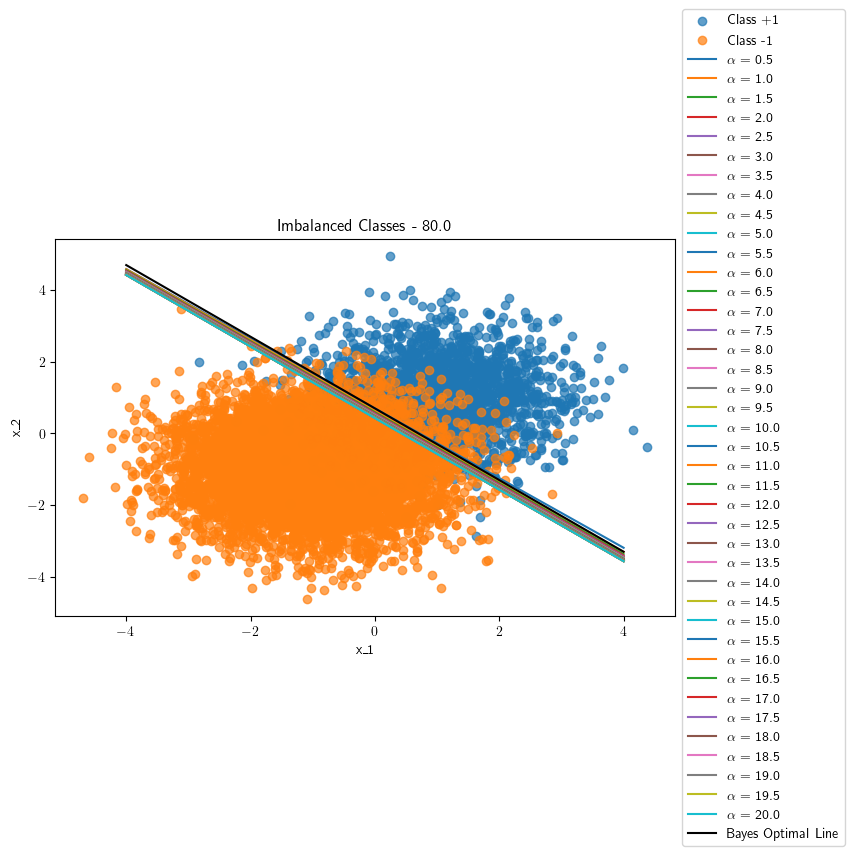

In [342]:
# plt.figure(2)
plt.figure(figsize=(8,5), dpi=100)
plt.scatter(x_ones[:,0],x_ones[:,1], label='Class +1', alpha=0.7)
plt.scatter(x_zeros[:,0],x_zeros[:,1], label='Class -1', alpha=0.7)
for p in range(num_a):
    plt.plot(x1,x2[:,p] ,label=r'$\alpha =$ {alpha:.1f}'.format(alpha=alpha_vals[p]))

plt.plot(x1,x3, color='k', label='Bayes Optimal Line')
plt.title('Imbalanced Classes - {imbalance:.1%}'.format(imbalance=pmix))
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Determine accuracy of model against a test set

In [343]:
n_test = int(1e4)
#keep pmix same
#pmix = 0.5
nmix = int(pmix*n_test)

[X_test, y_test] = gmm_generator_function(n_test, nmix, mu, sigma)

y_trans_test = (y_test + np.ones((n_test,1)))/2

# make predictions for each alpha 
bias = np.ones(n_test)
temp = np.zeros((n_test,3))
temp[:,0] = temp[:,0] + bias
temp[:,1] = temp[:,1] + X_test[:,0]
temp[:,2] = temp[:,1] + X_test[:,1]
counter = np.zeros((num_a,1))
y_preds = np.zeros((n_test,num_a))
for p in range(num_a):
  theta = thetas_super_storage[p,:]
  for q in range(n_test):
    y_hat = round(sigmoid(np.dot(np.squeeze(temp[q,:]),np.squeeze(theta))))
    y_preds[q,p] = y_hat
    if y_hat == y_trans_test[q]:
      counter[p] += 1
  counter[p] = counter[p]/n_test    

  print('The accuracy for alpha={:.2f} is: {:.2%}'.format(alpha_vals[p], float(counter[p])))


counter2 = 0
y_preds_bayes = np.zeros((n_test,1))

d = 1/inter3[1]
b = inter2 - inter1 + 2*np.log(pmix2/(1-pmix2))
for i in range(n_test):
    c = inter3[0]*X_test[i,0]
    if mu1 < 0:
        if X_test[i,1] >= d*(.5*b - c) :
            y_preds_bayes[i] = 1
        else:
            y_preds_bayes[i] = -1
    else:
        if X_test[i,1] < d*(.5*b - c) :
            y_preds_bayes[i] = 1
        else:
            y_preds_bayes[i] = -1

    if y_preds_bayes[i] == y_test[i]:
        counter2 += 1

print("The accuracy for Bayes' Optimal is: {:.2%}".format(counter2/n_test))
     



The accuracy for alpha=0.50 is: 93.00%
The accuracy for alpha=1.00 is: 92.84%
The accuracy for alpha=1.50 is: 92.74%
The accuracy for alpha=2.00 is: 92.68%
The accuracy for alpha=2.50 is: 92.66%
The accuracy for alpha=3.00 is: 92.61%
The accuracy for alpha=3.50 is: 92.54%
The accuracy for alpha=4.00 is: 92.55%
The accuracy for alpha=4.50 is: 92.52%
The accuracy for alpha=5.00 is: 92.52%
The accuracy for alpha=5.50 is: 92.52%
The accuracy for alpha=6.00 is: 92.48%
The accuracy for alpha=6.50 is: 92.47%
The accuracy for alpha=7.00 is: 92.47%
The accuracy for alpha=7.50 is: 92.46%
The accuracy for alpha=8.00 is: 92.43%
The accuracy for alpha=8.50 is: 92.42%
The accuracy for alpha=9.00 is: 92.40%
The accuracy for alpha=9.50 is: 92.39%
The accuracy for alpha=10.00 is: 92.38%
The accuracy for alpha=10.50 is: 92.39%
The accuracy for alpha=11.00 is: 92.39%
The accuracy for alpha=11.50 is: 92.38%
The accuracy for alpha=12.00 is: 92.39%
The accuracy for alpha=12.50 is: 92.39%
The accuracy for al

## Determine MCC Scores

In [344]:
from sklearn.metrics import matthews_corrcoef

MCC_alpha = np.zeros((num_a,1))
for p in range(num_a):
    #change to -1, 1
    pred = y_preds[:,p]
    pred[pred==0] = -1
    MCC_alpha[p] = matthews_corrcoef(y_test, pred)
    print('MCC score for alpha={:.2f} is: {:.4}'.format(alpha_vals[p],float(MCC_alpha[p])))

MCC_bayes = matthews_corrcoef(y_test, y_preds_bayes)
print('MCC score for Bayes optimal line is: {:.4}'.format(MCC_bayes))

MCC score for alpha=0.50 is: 0.7855
MCC score for alpha=1.00 is: 0.7829
MCC score for alpha=1.50 is: 0.7812
MCC score for alpha=2.00 is: 0.7805
MCC score for alpha=2.50 is: 0.7804
MCC score for alpha=3.00 is: 0.7794
MCC score for alpha=3.50 is: 0.7779
MCC score for alpha=4.00 is: 0.7786
MCC score for alpha=4.50 is: 0.7782
MCC score for alpha=5.00 is: 0.7783
MCC score for alpha=5.50 is: 0.7787
MCC score for alpha=6.00 is: 0.7779
MCC score for alpha=6.50 is: 0.7777
MCC score for alpha=7.00 is: 0.7777
MCC score for alpha=7.50 is: 0.7777
MCC score for alpha=8.00 is: 0.7769
MCC score for alpha=8.50 is: 0.7767
MCC score for alpha=9.00 is: 0.7763
MCC score for alpha=9.50 is: 0.7761
MCC score for alpha=10.00 is: 0.776
MCC score for alpha=10.50 is: 0.7763
MCC score for alpha=11.00 is: 0.7764
MCC score for alpha=11.50 is: 0.7762
MCC score for alpha=12.00 is: 0.7766
MCC score for alpha=12.50 is: 0.7766
MCC score for alpha=13.00 is: 0.7761
MCC score for alpha=13.50 is: 0.7761
MCC score for alpha=1

In [345]:
from scipy.stats import entropy
true_posterior = (posterior(X_test, 1-pmix, mu[1,:], mu[0,:], sigma)).astype(float)
np.save('true_posterior_{imbalance}_{noise}.npy'.format(imbalance=pmix, noise=pflip),np.array(true_posterior))
twisted_posterior = true_posterior
kl_list = []
bayes_estimated_posterior = sigmoid(X_test@bayes_theta[1:] + bayes_theta[0])
bayes_estimated_label = (bayes_estimated_posterior >0.5).astype(int)
y_preds_bayes[y_preds_bayes==-1] =0
df = pd.DataFrame(columns=['alpha','kl'])
for p in range(num_a):
    for e in range(experiments):
        theta = [theta1_vals[p+e], theta2_vals[p+e], theta3_vals[p+e]]
        np.save('theta_{imbalance}_{noise}_{alpha}.npy'.format(imbalance=pmix, noise=pflip, alpha=alpha_vals[p]),np.array(theta))
        estimated_posterior = sigmoid(X_test@theta[1:] + theta[0])
        np.save('posterior_{imbalance}_{noise}_{alpha}.npy'.format(imbalance=pmix, noise=pflip, alpha=alpha_vals[p]),np.array(estimated_posterior))
        print(estimated_posterior)
        kl = (entropy([twisted_posterior, 1-twisted_posterior], [estimated_posterior, 1-estimated_posterior], axis=0).mean())
        print(sigmoid(X_test@theta[1:] + theta[0]))
        df.loc[len(df.index)] = [alpha_vals[p], kl]
#print(np.argmin(kl_list))
print(df.head())
#plt.figure(0)
#plt.xlabel(r'$\alpha$')
#plt.ylabel(r'KL Divergence of True Posterior and Estimated')
#plt.plot(alpha_vals, kl_list, label='Imbalance Level {imbalance:.1%}, Noise {noise:.1%}'.format(imbalance=pmix, noise=pflip))
#plt.title('KL Divergence of True and Learned Posterior')
#plt.legend()
df.to_pickle('kl_{imbalance}_{noise}.pkl'.format(imbalance=pmix, noise=pflip))
np.save('kl_{imbalance}_{noise}.npy'.format(imbalance=pmix, noise=pflip),np.array(kl_list))


[0.05591809 0.04445206 0.06906799 ... 0.72338187 0.96877688 0.57040147]
[0.05591809 0.04445206 0.06906799 ... 0.72338187 0.96877688 0.57040147]
[0.05597653 0.04448387 0.06913323 ... 0.7229562  0.96866838 0.5703754 ]
[0.05597653 0.04448387 0.06913323 ... 0.7229562  0.96866838 0.5703754 ]
[0.05591328 0.04446531 0.0690546  ... 0.72317337 0.96871448 0.5699735 ]
[0.05591328 0.04446531 0.0690546  ... 0.72317337 0.96871448 0.5699735 ]
[0.05595352 0.04447276 0.06910829 ... 0.72319682 0.9687274  0.57042351]
[0.05595352 0.04447276 0.06910829 ... 0.72319682 0.9687274  0.57042351]
[0.05588785 0.04443933 0.06903555 ... 0.72375253 0.96886567 0.57048115]
[0.05588785 0.04443933 0.06903555 ... 0.72375253 0.96886567 0.57048115]
[0.05595438 0.04446507 0.06910781 ... 0.72295618 0.96867655 0.57035452]
[0.05595438 0.04446507 0.06910781 ... 0.72295618 0.96867655 0.57035452]
[0.05590271 0.0444529  0.06905009 ... 0.72360683 0.96882469 0.57036356]
[0.05590271 0.0444529  0.06905009 ... 0.72360683 0.96882469 0.57

In [346]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, penalty='none').fit(X, y.ravel())
lr_probs = clf.predict_proba(X_test)
lr_probs[:,1]

array([0.00326905, 0.00198916, 0.00514414, ..., 0.86983399, 0.99898279,
       0.63807235])

In [347]:
from sklearn.calibration import calibration_curve
val = 18
val2 = 38
val3 = 77
y_pred_ll = sigmoid(X_test@thetas_super_storage[2,1:] + thetas_super_storage[2,0])
y_pred_2 = sigmoid(X_test@thetas_super_storage[val,1:] + thetas_super_storage[val,0])
y_pred_3 = sigmoid(X_test@thetas_super_storage[val2,1:] + thetas_super_storage[val2,0])
y_pred_4 = sigmoid(X_test@thetas_super_storage[val3,1:] + thetas_super_storage[val3,0])
y_test[y_test==-1]=0
np.save('y_test_{i}_{n}.npy'.format(i=pmix,n=pflip),np.array(y_test))
prob_true, prob_pred = calibration_curve(y_test, y_pred_ll, n_bins=20)
prob_true2, prob_pred2 = calibration_curve(y_test, y_pred_2, n_bins=20)
prob_true3, prob_pred3 = calibration_curve(y_test, y_pred_3, n_bins=20)
prob_true4, prob_pred4 = calibration_curve(y_test, y_pred_4, n_bins=20)
prob_true_lr, prob_pred_lr = calibration_curve(y_test, lr_probs[:,1], n_bins=20)
prob_true_bayes, prob_pred_bayes = calibration_curve(y_test, true_posterior, n_bins=20)
plt.plot(prob_pred, prob_true, label=r'$\alpha={alpha}$'.format(alpha=alpha_vals[2]))
plt.plot(prob_pred2, prob_true2, label=r'$\alpha={alpha}$'.format(alpha=alpha_vals[val]))
plt.plot(prob_pred3, prob_true3, label=r'$\alpha={alpha}$'.format(alpha=alpha_vals[val2]))
plt.plot(prob_pred4, prob_true4, label=r'$\alpha={alpha}$'.format(alpha=alpha_vals[val3]))
#plt.plot(prob_pred_bayes, prob_true_bayes, label=r'Bayes')
#plt.plot(prob_pred_lr, prob_true_lr, label=r'SKLearn LR')
plt.plot(prob_true, prob_true, linestyle='dashed', color='black')
plt.title(r'Reliability Diagram, {noise:.1%} noise, {pmix:.1%} imbalance'.format(noise=pflip, pmix=pmix))
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction Positive')
plt.legend()
plt.savefig('reliability_{imbalance}_{noise}.png'.format(imbalance=pmix, noise=pflip))

IndexError: index 77 is out of bounds for axis 0 with size 40

(array([0.07939804, 0.25040922, 0.70236731, 1.60628351, 3.12706143,
        4.65394689, 5.3257765 , 5.8510251 , 4.75166756, 3.74392316,
        4.48293572, 4.80663544, 5.57007817, 5.46014242, 4.34246226,
        3.50572903, 1.67346647, 0.81230307, 0.23208659, 0.09772067]),
 array([0.3360292 , 0.3524024 , 0.3687756 , 0.3851488 , 0.40152199,
        0.41789519, 0.43426839, 0.45064159, 0.46701479, 0.48338799,
        0.49976119, 0.51613439, 0.53250759, 0.54888079, 0.56525399,
        0.58162719, 0.59800039, 0.61437359, 0.63074678, 0.64711998,
        0.66349318]),
 <BarContainer object of 20 artists>)

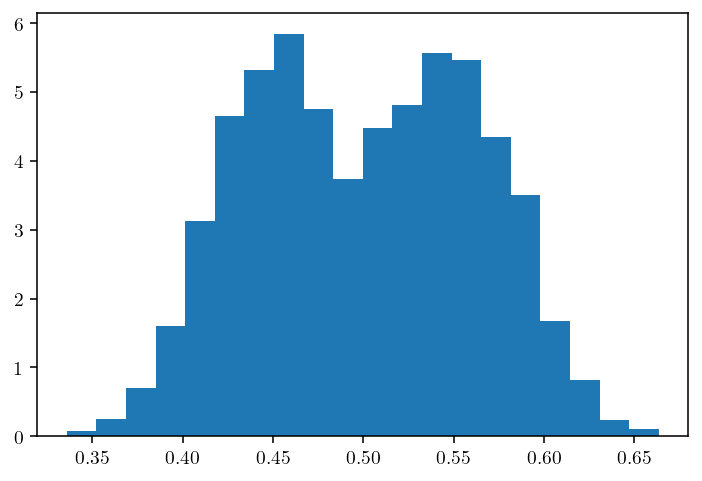

In [ ]:
plt.hist(y_pred_ll, bins=20, density=True)

(array([3301.,  475.,  286.,  203.,  154.,  102.,   97.,  117.,   98.,
         115.,  120.,  101.,   95.,  147.,  147.,  189.,  221.,  288.,
         493., 3251.]),
 array([1.99599707e-06, 5.00018074e-02, 1.00001619e-01, 1.50001430e-01,
        2.00001242e-01, 2.50001053e-01, 3.00000865e-01, 3.50000676e-01,
        4.00000487e-01, 4.50000299e-01, 5.00000110e-01, 5.49999922e-01,
        5.99999733e-01, 6.49999544e-01, 6.99999356e-01, 7.49999167e-01,
        7.99998979e-01, 8.49998790e-01, 8.99998602e-01, 9.49998413e-01,
        9.99998224e-01]),
 <BarContainer object of 20 artists>)

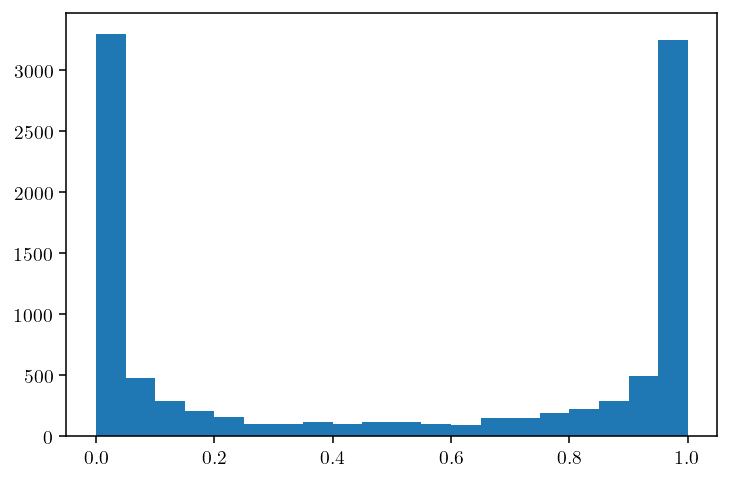

In [ ]:
plt.hist(true_posterior,bins=20)

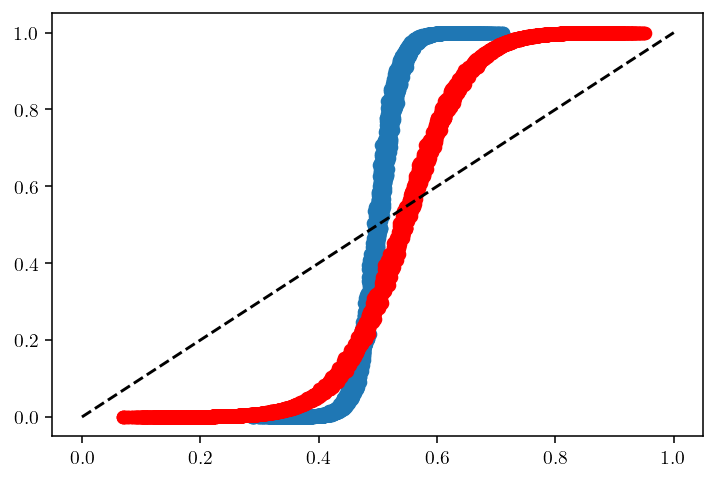

In [ ]:
true_posterior = posterior(X_test, 1-pmix, mu[1,:], mu[0,:], sigma)
plt.scatter(lr_probs[:,1], true_posterior)
plt.scatter(y_pred_2, true_posterior, color='red')
plt.plot(prob_true, prob_true, linestyle='dashed', color='black')

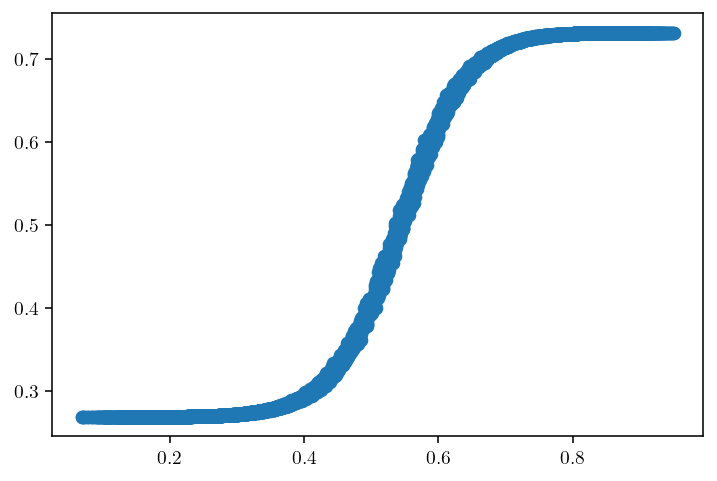

In [ ]:
a_tilted_posterior = alpha_tilted_posterior(X_test, 5.0,0.45, 1-pmix, mu[1,:], mu[0,:], sigma)
plt.scatter(y_pred_2, a_tilted_posterior)

In [ ]:
for exp in range(100):
    np.random.seed(exp)
    [X_test, y_test] = gmm_generator_function(n_test, nmix, mu, sigma)
    

